<a href="https://colab.research.google.com/github/RautRitesh/langgraph/blob/main/Langgraph_with_MessagesState.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install langchain langgraph langchain-groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 2.0 MB/s eta 0:00:00


In [13]:
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage, AnyMessage

In [39]:
from google.colab import userdata
api_key=userdata.get('groq_api_key')

In [40]:
llm=ChatGroq(model="openai/gpt-oss-20b", api_key=api_key)

In [41]:
class MessagesState(TypedDict):
  messages:Annotated[list[AnyMessage], add_messages]

In [42]:
def function1(state:MessagesState):
    message=state["messages"]
    print(message)
    print("hello")
    result=llm.invoke(message)
    return {"messages":[result.content]}



In [43]:
workflow=StateGraph(MessagesState)
workflow.add_node("chatbot",function1)
workflow.add_edge(START,"chatbot")
workflow.add_edge("chatbot",END)
app=workflow.compile()

In [44]:
from IPython.display import Image,display

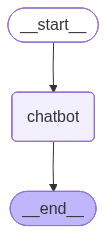

In [45]:
try:
  display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)

In [48]:
app.invoke({"messages":["What is Langgraph in 2 sentences?"]})

[HumanMessage(content='What is Langgraph in 2 sentences?', additional_kwargs={}, response_metadata={}, id='3589dc96-486e-4787-a32c-d4f79701a704')]
hello


{'messages': [HumanMessage(content='What is Langgraph in 2 sentences?', additional_kwargs={}, response_metadata={}, id='3589dc96-486e-4787-a32c-d4f79701a704'),
  HumanMessage(content='Langgraph is a framework for building and orchestrating complex, multi-step language model workflows, allowing developers to design modular “nodes” that can be chained, branched, or looped. It abstracts the control flow and state management of LLM-driven applications, enabling rapid prototyping and reliable production deployments across a variety of use cases.', additional_kwargs={}, response_metadata={}, id='669d0fcf-5a0b-4758-b770-de1044d229e3')]}